In [40]:
# Required Modules

import talib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

# Custom Functions

In [41]:
def plot(y_train, y_test, y_train_pred, y_test_pred, timestamp, train_size):
    plt.plot(timestamp[:train_size], y_train, label="training(actual)")
    plt.plot(timestamp[train_size:], y_test, label="testing(actual)")
    plt.plot(timestamp[:train_size], y_train_pred, label="training(forecast)")
    plt.plot(timestamp[train_size:], y_test_pred, label="testing(forecast)")
    plt.legend()
    
    return

# Loading and preprocessing data
The company which I have choosen is sbi, as I am only interested in Adj Closing price and Volume traded
I will load that into another data frame

In [42]:
data = pd.read_csv('sbi_2y.csv', index_col='Date')
data.index = pd.to_datetime(data.index)
print(data.head())
print()

sbi = data[['Adj Close', 'Volume']]
sbi.columns = ['Adj_Close', 'Volume']
print(sbi.head())

            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2018-01-02  9.30  9.39  9.30   9.37   8.588680   61500
2018-01-03  9.36  9.44  9.36   9.38   8.597844   19400
2018-01-04  9.43  9.45  9.42   9.42   8.634513   20700
2018-01-05  9.41  9.45  9.37   9.43   8.643680   40300
2018-01-08  9.41  9.47  9.41   9.41   8.625346   20100

            Adj_Close  Volume
Date                         
2018-01-02   8.588680   61500
2018-01-03   8.597844   19400
2018-01-04   8.634513   20700
2018-01-05   8.643680   40300
2018-01-08   8.625346   20100


# Exploratory Data Analysis
Showing the line plot and Histogram of the data

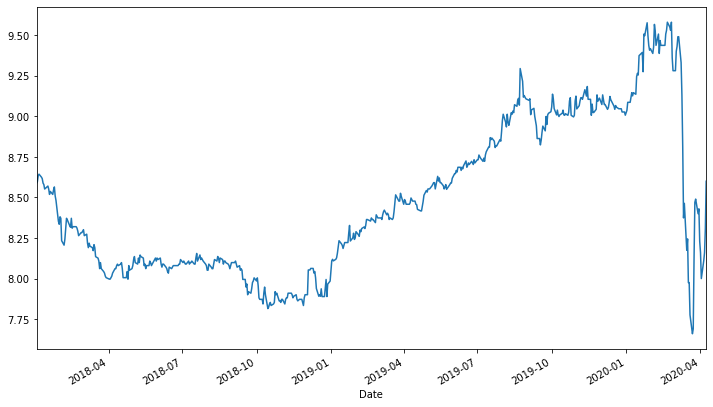

In [43]:
sbi['Adj_Close'].plot()

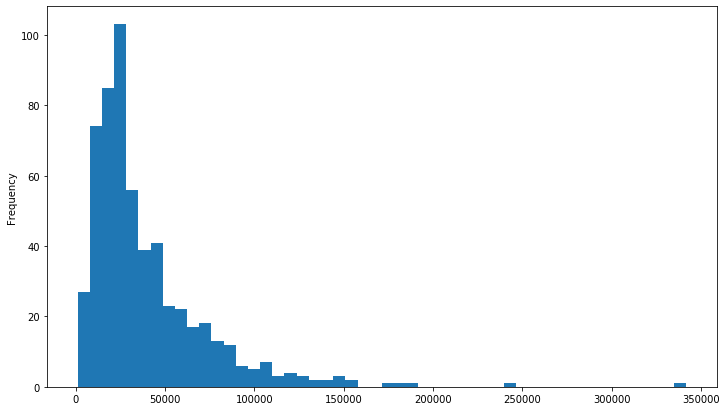

In [44]:
sbi['Volume'].plot.hist(bins=50)

# Expanding Feature Space

Indicators which I have selected are
* Relative Strength Index(RSI)
* Simple Moving Average(SMA)
* Rate Of Change Price(ROCP)

and calculated over the rolling windows of 7, 14, 30, 60

In [45]:
indicators = ['SMA', 'RSI', 'ROCP']
rolling_windows = [7, 14, 30, 60]
targets = ['Adj_Close']
features = ['Volume']

for n in rolling_windows:
    for ind in indicators:
        col_name = "Adj_Close_"+ind+"_"+str(n)
        features.append(col_name)
        if ind == 'SMA':
            sbi[col_name] = talib.SMA(sbi['Adj_Close'], timeperiod=n)
        elif ind == 'RSI':
            sbi[col_name] = talib.RSI(sbi['Adj_Close'], timeperiod=n)
        elif ind == 'ROCP':
            sbi[col_name] = talib.ROCP(sbi['Adj_Close'], timeperiod=n)
sbi = sbi.dropna()
timestamp = sbi.index
print(timestamp)

DatetimeIndex(['2018-03-29', '2018-04-02', '2018-04-03', '2018-04-04',
               '2018-04-05', '2018-04-06', '2018-04-09', '2018-04-10',
               '2018-04-11', '2018-04-12',
               ...
               '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09'],
              dtype='datetime64[ns]', name='Date', length=512, freq=None)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

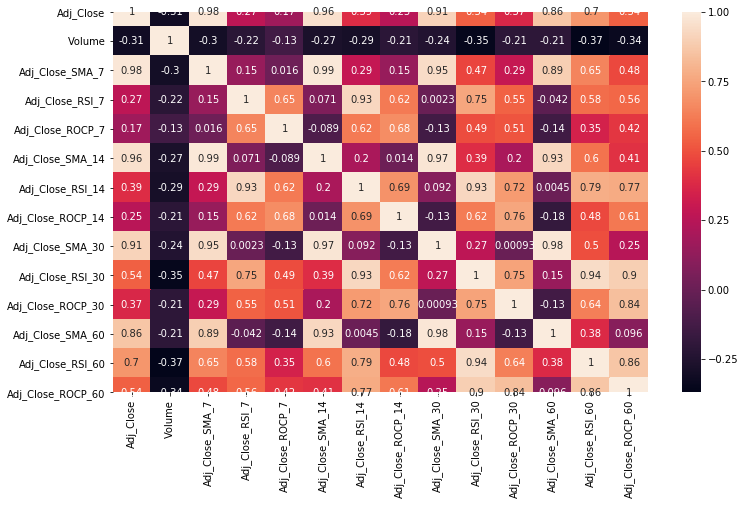

In [46]:
# Correlation Heatmap

sns.heatmap(sbi.corr(), annot=True)

# Train Test Split

Dividing the entire data into training and testing sets, with testing size of 0.25

In [47]:
length = len(sbi)
train_ratio = 0.75
train_size = int(train_ratio * length)

X_train = sbi[features][:train_size]
y_train = sbi[targets][:train_size]
X_test = sbi[features][train_size:]
y_test = sbi[targets][train_size:]

# Linear Regression

In [48]:
reg = LinearRegression()
reg.fit(X_train.values, y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
y_train_pred = reg.predict(X_train.values)
y_test_pred = reg.predict(X_test.values)

print("Training Error is:", np.sqrt(mean_squared_error(y_train_pred, y_train.values)))
print("Testing Error is:", np.sqrt(mean_squared_error(y_test_pred, y_test.values)))

Training Error is: 0.01199371243877711
Testing Error is: 0.08630394851037651


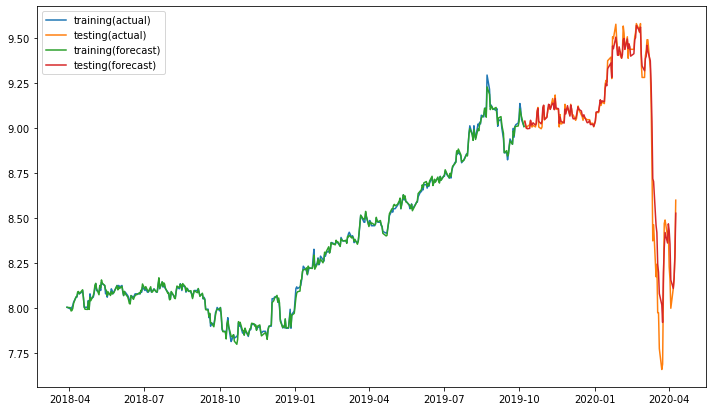

In [50]:
plot(y_train, y_test, y_train_pred, y_test_pred, timestamp, train_size)

# Random Forest

In [51]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train.values, y_train.values)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [52]:
y_train_pred = tree.predict(X_train.values)
y_test_pred = tree.predict(X_test.values)

print("Training Error is:", np.sqrt(mean_squared_error(y_train_pred, y_train)))
print("Testing Error is:", np.sqrt(mean_squared_error(y_test_pred, y_test)))

Training Error is: 0.023036306526200027
Testing Error is: 0.29395519452279284


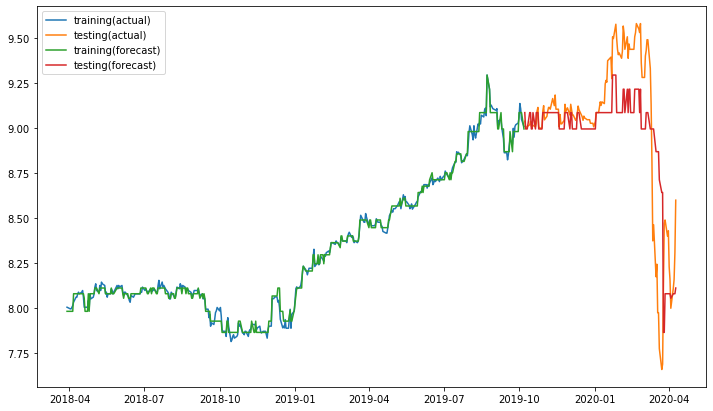

In [53]:
plot(y_train, y_test, y_train_pred, y_test_pred, timestamp, train_size)

In [54]:
forest = RandomForestRegressor(n_estimators=200, max_features=3, max_depth=7, random_state=42)
forest.fit(X_train.values, y_train.values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [55]:
y_train_pred = forest.predict(X_train.values)
y_test_pred = forest.predict(X_test.values)

print("Training Error is:", np.sqrt(mean_squared_error(y_train_pred, y_train)))
print("Testing Error is:", np.sqrt(mean_squared_error(y_test_pred, y_test)))

Training Error is: 0.008597554152375583
Testing Error is: 0.2955494326479104


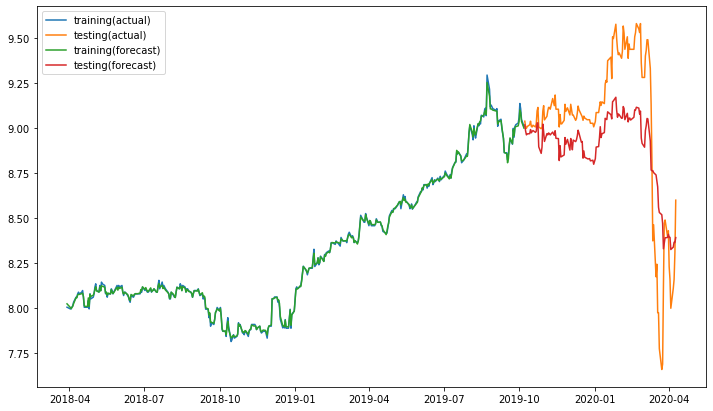

In [56]:
plot(y_train, y_test, y_train_pred, y_test_pred, timestamp, train_size)

# Gradient Boosting

In [57]:
gbr = GradientBoostingRegressor(max_features=4, learning_rate=0.01, n_estimators=200, subsample=0.6, random_state=42)
gbr.fit(X_train.values, y_train.values)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.6, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [58]:
y_train_pred = gbr.predict(X_train.values)
y_test_pred = gbr.predict(X_test.values)

print("Training Error is:", np.sqrt(mean_squared_error(y_train_pred, y_train)))
print("Testing Error is:", np.sqrt(mean_squared_error(y_test_pred, y_test)))

Training Error is: 0.058263330554587996
Testing Error is: 0.35531148201299395


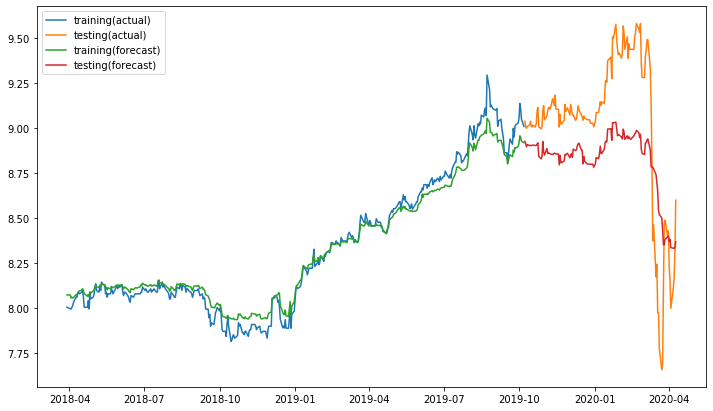

In [59]:
plot(y_train, y_test, y_train_pred, y_test_pred, timestamp, train_size)